In [1]:
#the project file was ran on cpu to get the expected results

In [12]:
#cell1
!pip install medmnist

In [13]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import medmnist
from medmnist import INFO


In [15]:
#cell3
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [16]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define constants
data_flag = 'breastmnist'
download = True
NUM_EPOCHS = 30
BATCH_SIZE = 32
patience = 8
info = INFO[data_flag]
task = info['task']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [17]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=train_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)


Using downloaded and verified file: C:\Users\agodw\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\agodw\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\agodw\.medmnist\breastmnist.npz


In [18]:
#cell6
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\agodw\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\agodw\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

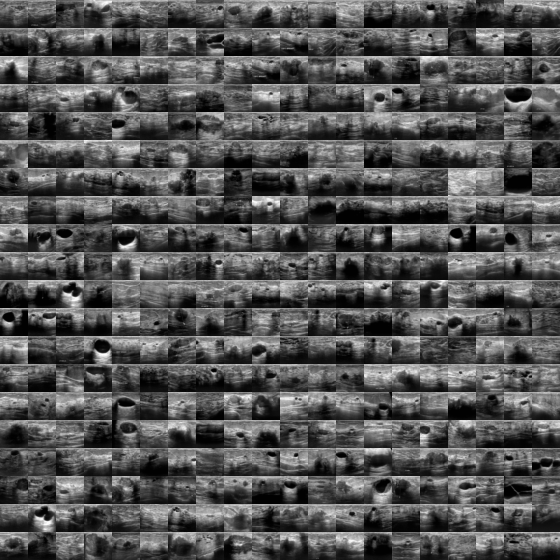

In [19]:
#cell7
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [20]:
# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)

# Define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Next, we can start to train and evaluate!

In [21]:
import sklearn.metrics as metrics
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define grids of learning rates and weight decays
learning_rates = [0.00019, 0.00020, 0.00021, 0.00022]
weight_decays = [6.1e-05,3e-05, 1e-05] 

best_lr = None
best_weight_decay = None
best_accuracy = 0.0
best_auc = 0.0

for lr in learning_rates:
    for weight_decay in weight_decays:
        print(f"Training with LR={lr} and Weight Decay={weight_decay}")
        
        #Reloading the model to start from scratch
        model.load_state_dict(torch.load('best_model.pth'))
        
        #Updateing optimizer with new learning rate and weight decay
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        
        #Training and validating the model
        best_val_loss = float('inf')
        counter = 0
        for epoch in range(NUM_EPOCHS):
            train_loss = 0.0
            val_loss = 0.0
            model.train()
            
            #Training
            train_outputs = []
            train_targets = []
            for inputs, targets in tqdm(train_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                if task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32)
                    loss = criterion(outputs, targets)
                else:
                    targets = targets.squeeze().long()
                    loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                train_outputs.extend(outputs.detach().cpu().numpy())
                train_targets.extend(targets.detach().cpu().numpy())
            
            #Calculating training accuracy and AUC
            train_outputs_proba = torch.softmax(torch.tensor(train_outputs), dim=1).cpu().numpy()
            train_targets_onehot = np.eye(n_classes)[train_targets]  # Convert train_targets to one-hot encoded format
            train_targets_onehot = train_targets_onehot.reshape(-1, n_classes)  # Reshape to 2D
            train_outputs_proba_reshaped = train_outputs_proba.reshape(-1, n_classes)
            
            train_accuracy = metrics.accuracy_score(train_targets, np.argmax(train_outputs, axis=1))
            train_auc = metrics.roc_auc_score(train_targets_onehot, train_outputs_proba_reshaped, multi_class='ovr')
            
            #Validate the model
            model.eval()
            val_outputs = []
            val_targets = []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    if task == 'multi-label, binary-class':
                        targets = targets.to(torch.float32)
                        outputs = outputs.softmax(dim=-1)
                    else:
                        targets = targets.squeeze().long()
                        outputs = outputs.softmax(dim=-1)
                    val_loss += criterion(outputs, targets).sum().item()

                    val_outputs.extend(outputs.detach().cpu().numpy())
                    val_targets.extend(targets.detach().cpu().numpy())
            
            #Calculate val accuracy and AUC
            val_outputs_proba = torch.softmax(torch.tensor(val_outputs), dim=1).cpu().numpy()
            val_targets_onehot = np.eye(n_classes)[val_targets]  # Convert val_targets to one-hot encoded format
            val_targets_onehot = val_targets_onehot.reshape(-1, n_classes)  # Reshape to 2D
            val_outputs_proba_reshaped = val_outputs_proba.reshape(-1, n_classes)
            
            val_accuracy = metrics.accuracy_score(val_targets, np.argmax(val_outputs, axis=1))
            val_auc = metrics.roc_auc_score(val_targets_onehot, val_outputs_proba_reshaped, multi_class='ovr')

            #Early stopping and LR scheduler
            val_loss /= len(val_dataset)
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping!")
                    break

            print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | Train Loss: {train_loss / len(train_dataset):.4f} | Val Loss: {val_loss:.4f}')
            print(f'Train Accuracy: {train_accuracy:.4f} | Train AUC: {train_auc:.4f} | Val Accuracy: {val_accuracy:.4f} | Val AUC: {val_auc:.4f}')

        model.eval()
        test_outputs = []
        test_targets = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_outputs.extend(outputs.cpu().numpy())
                test_targets.extend(targets.cpu().numpy())

        test_outputs_proba = torch.softmax(torch.tensor(test_outputs), dim=1).cpu().numpy()
        test_targets_onehot = np.eye(n_classes)[test_targets]  
        test_targets_onehot = test_targets_onehot.reshape(-1, n_classes)  

        #Reshape test_outputs_proba to have shape (n_samples, n_classes)
        test_outputs_proba_reshaped = test_outputs_proba.reshape(-1, n_classes)

        test_accuracy = metrics.accuracy_score(test_targets, np.argmax(test_outputs, axis=1))
        test_auc = metrics.roc_auc_score(test_targets_onehot, test_outputs_proba_reshaped, multi_class='ovr')
        
        print(f"Train Accuracy (LR={lr}, Weight Decay={weight_decay}): {train_accuracy:.4f} | Train AUC (LR={lr}, Weight Decay={weight_decay}): {train_auc:.4f}")
        print(f"Val Accuracy (LR={lr}, Weight Decay={weight_decay}): {val_accuracy:.4f} | Val AUC (LR={lr}, Weight Decay={weight_decay}): {val_auc:.4f}")
        print(f"Test Accuracy (LR={lr}, Weight Decay={weight_decay}): {test_accuracy:.4f} | Test AUC (LR={lr}, Weight Decay={weight_decay}): {test_auc:.4f}")
        
        #Update best LR and weight decay based on accuracy and AUC
        if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
            best_lr = lr
            best_weight_decay = weight_decay
            best_accuracy = test_accuracy
            best_auc = test_auc

print(" ")
print(f"Best LR: {best_lr} | Best Weight Decay: {best_weight_decay} | Best Test Accuracy: {best_accuracy:.4f} | Best Test AUC: {best_auc:.4f}")

C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training with LR=0.00019 and Weight Decay=6.1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.48it/s]


Epoch 1/30 | Train Loss: 0.2224 | Val Loss: 0.0129
Train Accuracy: 0.9139 | Train AUC: 0.9603 | Val Accuracy: 0.8077 | Val AUC: 0.8739


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.27it/s]


Epoch 2/30 | Train Loss: 0.2820 | Val Loss: 0.0143
Train Accuracy: 0.8938 | Train AUC: 0.9257 | Val Accuracy: 0.8205 | Val AUC: 0.8354


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.26it/s]


Epoch 3/30 | Train Loss: 0.3516 | Val Loss: 0.0134
Train Accuracy: 0.8645 | Train AUC: 0.8840 | Val Accuracy: 0.7821 | Val AUC: 0.8638


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.63it/s]


Epoch 4/30 | Train Loss: 0.3163 | Val Loss: 0.0124
Train Accuracy: 0.8864 | Train AUC: 0.9316 | Val Accuracy: 0.8462 | Val AUC: 0.8997


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.21it/s]


Epoch 5/30 | Train Loss: 0.2590 | Val Loss: 0.0108
Train Accuracy: 0.8974 | Train AUC: 0.9489 | Val Accuracy: 0.9103 | Val AUC: 0.9023


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.98it/s]


Epoch 6/30 | Train Loss: 0.2455 | Val Loss: 0.0113
Train Accuracy: 0.8919 | Train AUC: 0.9557 | Val Accuracy: 0.8590 | Val AUC: 0.9256


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.91it/s]


Epoch 7/30 | Train Loss: 0.2349 | Val Loss: 0.0115
Train Accuracy: 0.9103 | Train AUC: 0.9537 | Val Accuracy: 0.8718 | Val AUC: 0.9131


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.01it/s]


Epoch 8/30 | Train Loss: 0.2239 | Val Loss: 0.0132
Train Accuracy: 0.9139 | Train AUC: 0.9595 | Val Accuracy: 0.7949 | Val AUC: 0.8463


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.67it/s]


Epoch 9/30 | Train Loss: 0.2210 | Val Loss: 0.0131
Train Accuracy: 0.9084 | Train AUC: 0.9624 | Val Accuracy: 0.8205 | Val AUC: 0.7978


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.86it/s]


Epoch 10/30 | Train Loss: 0.2285 | Val Loss: 0.0122
Train Accuracy: 0.9066 | Train AUC: 0.9566 | Val Accuracy: 0.8590 | Val AUC: 0.8647


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.51it/s]


Epoch 11/30 | Train Loss: 0.1601 | Val Loss: 0.0125
Train Accuracy: 0.9414 | Train AUC: 0.9797 | Val Accuracy: 0.8462 | Val AUC: 0.8429


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.32it/s]


Epoch 12/30 | Train Loss: 0.1523 | Val Loss: 0.0126
Train Accuracy: 0.9505 | Train AUC: 0.9830 | Val Accuracy: 0.8333 | Val AUC: 0.8772


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.30it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00019, Weight Decay=6.1e-05): 0.9304 | Train AUC (LR=0.00019, Weight Decay=6.1e-05): 0.9761
Val Accuracy (LR=0.00019, Weight Decay=6.1e-05): 0.8205 | Val AUC (LR=0.00019, Weight Decay=6.1e-05): 0.8446
Test Accuracy (LR=0.00019, Weight Decay=6.1e-05): 0.8141 | Test AUC (LR=0.00019, Weight Decay=6.1e-05): 0.8584
Training with LR=0.00019 and Weight Decay=3e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.11it/s]


Epoch 1/30 | Train Loss: 0.2852 | Val Loss: 0.0122
Train Accuracy: 0.8938 | Train AUC: 0.9387 | Val Accuracy: 0.8590 | Val AUC: 0.8764


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.30it/s]


Epoch 2/30 | Train Loss: 0.2905 | Val Loss: 0.0133
Train Accuracy: 0.8864 | Train AUC: 0.9366 | Val Accuracy: 0.8462 | Val AUC: 0.8755


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.23it/s]


Epoch 3/30 | Train Loss: 0.2509 | Val Loss: 0.0134
Train Accuracy: 0.8864 | Train AUC: 0.9452 | Val Accuracy: 0.8333 | Val AUC: 0.8672


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.84it/s]


Epoch 4/30 | Train Loss: 0.3030 | Val Loss: 0.0125
Train Accuracy: 0.8828 | Train AUC: 0.9266 | Val Accuracy: 0.8077 | Val AUC: 0.8480


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.36it/s]


Epoch 5/30 | Train Loss: 0.3104 | Val Loss: 0.0128
Train Accuracy: 0.8755 | Train AUC: 0.9188 | Val Accuracy: 0.8077 | Val AUC: 0.8279


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.04it/s]


Epoch 6/30 | Train Loss: 0.3083 | Val Loss: 0.0128
Train Accuracy: 0.8681 | Train AUC: 0.9239 | Val Accuracy: 0.7949 | Val AUC: 0.8513


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.97it/s]


Epoch 7/30 | Train Loss: 0.2700 | Val Loss: 0.0127
Train Accuracy: 0.8938 | Train AUC: 0.9362 | Val Accuracy: 0.7821 | Val AUC: 0.8496


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.37it/s]


Epoch 8/30 | Train Loss: 0.2808 | Val Loss: 0.0130
Train Accuracy: 0.8901 | Train AUC: 0.9346 | Val Accuracy: 0.7821 | Val AUC: 0.8513


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.03it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00019, Weight Decay=3e-05): 0.9029 | Train AUC (LR=0.00019, Weight Decay=3e-05): 0.9509
Val Accuracy (LR=0.00019, Weight Decay=3e-05): 0.8333 | Val AUC (LR=0.00019, Weight Decay=3e-05): 0.8246
Test Accuracy (LR=0.00019, Weight Decay=3e-05): 0.8397 | Test AUC (LR=0.00019, Weight Decay=3e-05): 0.8678
Training with LR=0.00019 and Weight Decay=1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.79it/s]


Epoch 1/30 | Train Loss: 0.2625 | Val Loss: 0.0131
Train Accuracy: 0.8974 | Train AUC: 0.9367 | Val Accuracy: 0.8333 | Val AUC: 0.8555


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch 2/30 | Train Loss: 0.2675 | Val Loss: 0.0117
Train Accuracy: 0.8883 | Train AUC: 0.9464 | Val Accuracy: 0.8718 | Val AUC: 0.8538


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.94it/s]


Epoch 3/30 | Train Loss: 0.3011 | Val Loss: 0.0120
Train Accuracy: 0.8828 | Train AUC: 0.9271 | Val Accuracy: 0.8205 | Val AUC: 0.8672


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch 4/30 | Train Loss: 0.2822 | Val Loss: 0.0124
Train Accuracy: 0.8791 | Train AUC: 0.9396 | Val Accuracy: 0.8590 | Val AUC: 0.8772


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch 5/30 | Train Loss: 0.2143 | Val Loss: 0.0119
Train Accuracy: 0.9176 | Train AUC: 0.9597 | Val Accuracy: 0.8718 | Val AUC: 0.8897


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.84it/s]


Epoch 6/30 | Train Loss: 0.2004 | Val Loss: 0.0119
Train Accuracy: 0.9249 | Train AUC: 0.9665 | Val Accuracy: 0.8590 | Val AUC: 0.9114


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.21it/s]


Epoch 7/30 | Train Loss: 0.1972 | Val Loss: 0.0124
Train Accuracy: 0.9267 | Train AUC: 0.9689 | Val Accuracy: 0.8718 | Val AUC: 0.9114


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.49it/s]


Epoch 8/30 | Train Loss: 0.1685 | Val Loss: 0.0118
Train Accuracy: 0.9249 | Train AUC: 0.9791 | Val Accuracy: 0.8974 | Val AUC: 0.9148


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.43it/s]


Epoch 9/30 | Train Loss: 0.1653 | Val Loss: 0.0118
Train Accuracy: 0.9396 | Train AUC: 0.9775 | Val Accuracy: 0.8718 | Val AUC: 0.9140


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.64it/s]


Epoch 10/30 | Train Loss: 0.1460 | Val Loss: 0.0112
Train Accuracy: 0.9341 | Train AUC: 0.9806 | Val Accuracy: 0.8846 | Val AUC: 0.9190


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.65it/s]


Epoch 11/30 | Train Loss: 0.1634 | Val Loss: 0.0115
Train Accuracy: 0.9377 | Train AUC: 0.9734 | Val Accuracy: 0.8590 | Val AUC: 0.9089


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch 12/30 | Train Loss: 0.1673 | Val Loss: 0.0117
Train Accuracy: 0.9322 | Train AUC: 0.9761 | Val Accuracy: 0.8718 | Val AUC: 0.9081


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.79it/s]


Epoch 13/30 | Train Loss: 0.1687 | Val Loss: 0.0114
Train Accuracy: 0.9267 | Train AUC: 0.9745 | Val Accuracy: 0.8846 | Val AUC: 0.9056


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.86it/s]


Epoch 14/30 | Train Loss: 0.1556 | Val Loss: 0.0115
Train Accuracy: 0.9377 | Train AUC: 0.9806 | Val Accuracy: 0.8718 | Val AUC: 0.8989


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.92it/s]


Epoch 15/30 | Train Loss: 0.1534 | Val Loss: 0.0118
Train Accuracy: 0.9487 | Train AUC: 0.9766 | Val Accuracy: 0.8590 | Val AUC: 0.8972


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.76it/s]


Epoch 16/30 | Train Loss: 0.1391 | Val Loss: 0.0117
Train Accuracy: 0.9597 | Train AUC: 0.9797 | Val Accuracy: 0.8718 | Val AUC: 0.9181


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.82it/s]


Epoch 17/30 | Train Loss: 0.1682 | Val Loss: 0.0114
Train Accuracy: 0.9432 | Train AUC: 0.9740 | Val Accuracy: 0.8462 | Val AUC: 0.8997


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch 18/30 | Train Loss: 0.1484 | Val Loss: 0.0110
Train Accuracy: 0.9396 | Train AUC: 0.9792 | Val Accuracy: 0.8974 | Val AUC: 0.9089


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch 19/30 | Train Loss: 0.1409 | Val Loss: 0.0111
Train Accuracy: 0.9579 | Train AUC: 0.9801 | Val Accuracy: 0.8718 | Val AUC: 0.9039


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.33it/s]


Epoch 20/30 | Train Loss: 0.1712 | Val Loss: 0.0111
Train Accuracy: 0.9341 | Train AUC: 0.9726 | Val Accuracy: 0.8974 | Val AUC: 0.9165


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.52it/s]


Epoch 21/30 | Train Loss: 0.1319 | Val Loss: 0.0113
Train Accuracy: 0.9487 | Train AUC: 0.9878 | Val Accuracy: 0.8718 | Val AUC: 0.9190


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.54it/s]


Epoch 22/30 | Train Loss: 0.1136 | Val Loss: 0.0119
Train Accuracy: 0.9615 | Train AUC: 0.9904 | Val Accuracy: 0.8846 | Val AUC: 0.8947


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch 23/30 | Train Loss: 0.1452 | Val Loss: 0.0113
Train Accuracy: 0.9396 | Train AUC: 0.9812 | Val Accuracy: 0.8846 | Val AUC: 0.9165


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.41it/s]


Epoch 24/30 | Train Loss: 0.1669 | Val Loss: 0.0109
Train Accuracy: 0.9396 | Train AUC: 0.9781 | Val Accuracy: 0.9103 | Val AUC: 0.9056


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch 25/30 | Train Loss: 0.1532 | Val Loss: 0.0114
Train Accuracy: 0.9451 | Train AUC: 0.9777 | Val Accuracy: 0.8718 | Val AUC: 0.9098


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.39it/s]


Epoch 26/30 | Train Loss: 0.1620 | Val Loss: 0.0123
Train Accuracy: 0.9414 | Train AUC: 0.9788 | Val Accuracy: 0.8590 | Val AUC: 0.8947


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.16it/s]


Epoch 27/30 | Train Loss: 0.1985 | Val Loss: 0.0114
Train Accuracy: 0.9139 | Train AUC: 0.9715 | Val Accuracy: 0.8718 | Val AUC: 0.8972


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.20it/s]


Epoch 28/30 | Train Loss: 0.1297 | Val Loss: 0.0114
Train Accuracy: 0.9542 | Train AUC: 0.9876 | Val Accuracy: 0.8590 | Val AUC: 0.9131


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch 29/30 | Train Loss: 0.1326 | Val Loss: 0.0117
Train Accuracy: 0.9597 | Train AUC: 0.9815 | Val Accuracy: 0.8846 | Val AUC: 0.9064


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.56it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 30/30 | Train Loss: 0.1908 | Val Loss: 0.0112
Train Accuracy: 0.9359 | Train AUC: 0.9648 | Val Accuracy: 0.8718 | Val AUC: 0.9098
Train Accuracy (LR=0.00019, Weight Decay=1e-05): 0.9359 | Train AUC (LR=0.00019, Weight Decay=1e-05): 0.9648
Val Accuracy (LR=0.00019, Weight Decay=1e-05): 0.8718 | Val AUC (LR=0.00019, Weight Decay=1e-05): 0.9098
Test Accuracy (LR=0.00019, Weight Decay=1e-05): 0.8526 | Test AUC (LR=0.00019, Weight Decay=1e-05): 0.9062
Training with LR=0.0002 and Weight Decay=6.1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.35it/s]


Epoch 1/30 | Train Loss: 0.2807 | Val Loss: 0.0125
Train Accuracy: 0.8993 | Train AUC: 0.9407 | Val Accuracy: 0.8590 | Val AUC: 0.8805


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.29it/s]


Epoch 2/30 | Train Loss: 0.2834 | Val Loss: 0.0118
Train Accuracy: 0.8993 | Train AUC: 0.9293 | Val Accuracy: 0.8462 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.11it/s]


Epoch 3/30 | Train Loss: 0.1985 | Val Loss: 0.0122
Train Accuracy: 0.9286 | Train AUC: 0.9678 | Val Accuracy: 0.8205 | Val AUC: 0.8855


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch 4/30 | Train Loss: 0.2083 | Val Loss: 0.0112
Train Accuracy: 0.9103 | Train AUC: 0.9636 | Val Accuracy: 0.8846 | Val AUC: 0.8764


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch 5/30 | Train Loss: 0.2002 | Val Loss: 0.0108
Train Accuracy: 0.9322 | Train AUC: 0.9635 | Val Accuracy: 0.8718 | Val AUC: 0.8672


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch 6/30 | Train Loss: 0.2127 | Val Loss: 0.0109
Train Accuracy: 0.9267 | Train AUC: 0.9574 | Val Accuracy: 0.8590 | Val AUC: 0.9240


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.20it/s]


Epoch 7/30 | Train Loss: 0.2777 | Val Loss: 0.0119
Train Accuracy: 0.8791 | Train AUC: 0.9380 | Val Accuracy: 0.8462 | Val AUC: 0.8588


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.18it/s]


Epoch 8/30 | Train Loss: 0.2451 | Val Loss: 0.0117
Train Accuracy: 0.8974 | Train AUC: 0.9505 | Val Accuracy: 0.8462 | Val AUC: 0.9006


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.33it/s]


Epoch 9/30 | Train Loss: 0.1952 | Val Loss: 0.0109
Train Accuracy: 0.9267 | Train AUC: 0.9659 | Val Accuracy: 0.8590 | Val AUC: 0.9048


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.51it/s]


Epoch 10/30 | Train Loss: 0.2095 | Val Loss: 0.0107
Train Accuracy: 0.9212 | Train AUC: 0.9649 | Val Accuracy: 0.8846 | Val AUC: 0.9023


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.45it/s]


Epoch 11/30 | Train Loss: 0.1623 | Val Loss: 0.0109
Train Accuracy: 0.9322 | Train AUC: 0.9814 | Val Accuracy: 0.8718 | Val AUC: 0.8981


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.41it/s]


Epoch 12/30 | Train Loss: 0.1542 | Val Loss: 0.0108
Train Accuracy: 0.9487 | Train AUC: 0.9791 | Val Accuracy: 0.8718 | Val AUC: 0.9081


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.16it/s]


Epoch 13/30 | Train Loss: 0.1902 | Val Loss: 0.0107
Train Accuracy: 0.9249 | Train AUC: 0.9704 | Val Accuracy: 0.8846 | Val AUC: 0.9156


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.55it/s]


Epoch 14/30 | Train Loss: 0.1540 | Val Loss: 0.0111
Train Accuracy: 0.9432 | Train AUC: 0.9809 | Val Accuracy: 0.8718 | Val AUC: 0.9148


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.49it/s]


Epoch 15/30 | Train Loss: 0.1993 | Val Loss: 0.0114
Train Accuracy: 0.9249 | Train AUC: 0.9671 | Val Accuracy: 0.8718 | Val AUC: 0.9089


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.56it/s]


Epoch 16/30 | Train Loss: 0.1600 | Val Loss: 0.0108
Train Accuracy: 0.9377 | Train AUC: 0.9786 | Val Accuracy: 0.8718 | Val AUC: 0.9140


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.62it/s]


Epoch 17/30 | Train Loss: 0.1517 | Val Loss: 0.0111
Train Accuracy: 0.9451 | Train AUC: 0.9825 | Val Accuracy: 0.8846 | Val AUC: 0.9064


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.54it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.0002, Weight Decay=6.1e-05): 0.9212 | Train AUC (LR=0.0002, Weight Decay=6.1e-05): 0.9731
Val Accuracy (LR=0.0002, Weight Decay=6.1e-05): 0.8846 | Val AUC (LR=0.0002, Weight Decay=6.1e-05): 0.9114
Test Accuracy (LR=0.0002, Weight Decay=6.1e-05): 0.8462 | Test AUC (LR=0.0002, Weight Decay=6.1e-05): 0.8657
Training with LR=0.0002 and Weight Decay=3e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.95it/s]


Epoch 1/30 | Train Loss: 0.3242 | Val Loss: 0.0108
Train Accuracy: 0.8810 | Train AUC: 0.9218 | Val Accuracy: 0.8590 | Val AUC: 0.8939


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.77it/s]


Epoch 2/30 | Train Loss: 0.2232 | Val Loss: 0.0117
Train Accuracy: 0.9103 | Train AUC: 0.9647 | Val Accuracy: 0.8590 | Val AUC: 0.9098


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch 3/30 | Train Loss: 0.2103 | Val Loss: 0.0115
Train Accuracy: 0.9158 | Train AUC: 0.9628 | Val Accuracy: 0.8718 | Val AUC: 0.8881


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.77it/s]


Epoch 4/30 | Train Loss: 0.1800 | Val Loss: 0.0121
Train Accuracy: 0.9396 | Train AUC: 0.9716 | Val Accuracy: 0.8590 | Val AUC: 0.8947


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.16it/s]


Epoch 5/30 | Train Loss: 0.1763 | Val Loss: 0.0110
Train Accuracy: 0.9176 | Train AUC: 0.9774 | Val Accuracy: 0.9103 | Val AUC: 0.9273


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.82it/s]


Epoch 6/30 | Train Loss: 0.1722 | Val Loss: 0.0111
Train Accuracy: 0.9322 | Train AUC: 0.9742 | Val Accuracy: 0.8846 | Val AUC: 0.9348


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.12it/s]


Epoch 7/30 | Train Loss: 0.1848 | Val Loss: 0.0113
Train Accuracy: 0.9194 | Train AUC: 0.9743 | Val Accuracy: 0.8718 | Val AUC: 0.9365


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.21it/s]


Epoch 8/30 | Train Loss: 0.1411 | Val Loss: 0.0117
Train Accuracy: 0.9469 | Train AUC: 0.9812 | Val Accuracy: 0.8718 | Val AUC: 0.9340


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.15it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.0002, Weight Decay=3e-05): 0.9249 | Train AUC (LR=0.0002, Weight Decay=3e-05): 0.9723
Val Accuracy (LR=0.0002, Weight Decay=3e-05): 0.8590 | Val AUC (LR=0.0002, Weight Decay=3e-05): 0.9282
Test Accuracy (LR=0.0002, Weight Decay=3e-05): 0.8141 | Test AUC (LR=0.0002, Weight Decay=3e-05): 0.8818
Training with LR=0.0002 and Weight Decay=1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.37it/s]


Epoch 1/30 | Train Loss: 0.2544 | Val Loss: 0.0108
Train Accuracy: 0.9048 | Train AUC: 0.9455 | Val Accuracy: 0.8462 | Val AUC: 0.8580


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.43it/s]


Epoch 2/30 | Train Loss: 0.2371 | Val Loss: 0.0115
Train Accuracy: 0.9139 | Train AUC: 0.9497 | Val Accuracy: 0.8462 | Val AUC: 0.8555


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.49it/s]


Epoch 3/30 | Train Loss: 0.1972 | Val Loss: 0.0109
Train Accuracy: 0.9322 | Train AUC: 0.9676 | Val Accuracy: 0.8718 | Val AUC: 0.8705


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.36it/s]


Epoch 4/30 | Train Loss: 0.1505 | Val Loss: 0.0108
Train Accuracy: 0.9432 | Train AUC: 0.9818 | Val Accuracy: 0.8846 | Val AUC: 0.8872


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.49it/s]


Epoch 5/30 | Train Loss: 0.1731 | Val Loss: 0.0117
Train Accuracy: 0.9359 | Train AUC: 0.9728 | Val Accuracy: 0.8462 | Val AUC: 0.8855


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.46it/s]


Epoch 6/30 | Train Loss: 0.1353 | Val Loss: 0.0104
Train Accuracy: 0.9505 | Train AUC: 0.9854 | Val Accuracy: 0.8846 | Val AUC: 0.8922


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.30it/s]


Epoch 7/30 | Train Loss: 0.2019 | Val Loss: 0.0109
Train Accuracy: 0.9212 | Train AUC: 0.9678 | Val Accuracy: 0.8718 | Val AUC: 0.8814


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.56it/s]


Epoch 8/30 | Train Loss: 0.1210 | Val Loss: 0.0104
Train Accuracy: 0.9560 | Train AUC: 0.9884 | Val Accuracy: 0.8974 | Val AUC: 0.8989


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.35it/s]


Epoch 9/30 | Train Loss: 0.1422 | Val Loss: 0.0105
Train Accuracy: 0.9505 | Train AUC: 0.9792 | Val Accuracy: 0.8846 | Val AUC: 0.8822


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.50it/s]


Epoch 10/30 | Train Loss: 0.1326 | Val Loss: 0.0105
Train Accuracy: 0.9487 | Train AUC: 0.9867 | Val Accuracy: 0.8846 | Val AUC: 0.8883


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.49it/s]


Epoch 11/30 | Train Loss: 0.1133 | Val Loss: 0.0105
Train Accuracy: 0.9597 | Train AUC: 0.9888 | Val Accuracy: 0.8846 | Val AUC: 0.8847


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.34it/s]


Epoch 12/30 | Train Loss: 0.1147 | Val Loss: 0.0104
Train Accuracy: 0.9652 | Train AUC: 0.9879 | Val Accuracy: 0.8846 | Val AUC: 0.8872


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.34it/s]


Epoch 13/30 | Train Loss: 0.1356 | Val Loss: 0.0104
Train Accuracy: 0.9542 | Train AUC: 0.9833 | Val Accuracy: 0.8846 | Val AUC: 0.8956


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.36it/s]


Epoch 14/30 | Train Loss: 0.1299 | Val Loss: 0.0103
Train Accuracy: 0.9542 | Train AUC: 0.9849 | Val Accuracy: 0.8974 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.33it/s]


Epoch 15/30 | Train Loss: 0.1394 | Val Loss: 0.0104
Train Accuracy: 0.9524 | Train AUC: 0.9843 | Val Accuracy: 0.8974 | Val AUC: 0.8822


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch 16/30 | Train Loss: 0.1377 | Val Loss: 0.0102
Train Accuracy: 0.9487 | Train AUC: 0.9828 | Val Accuracy: 0.8974 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.04it/s]


Epoch 17/30 | Train Loss: 0.1241 | Val Loss: 0.0101
Train Accuracy: 0.9634 | Train AUC: 0.9853 | Val Accuracy: 0.8974 | Val AUC: 0.8997


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.28it/s]


Epoch 18/30 | Train Loss: 0.1365 | Val Loss: 0.0106
Train Accuracy: 0.9542 | Train AUC: 0.9837 | Val Accuracy: 0.8846 | Val AUC: 0.8914


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.37it/s]


Epoch 19/30 | Train Loss: 0.1134 | Val Loss: 0.0105
Train Accuracy: 0.9615 | Train AUC: 0.9886 | Val Accuracy: 0.8846 | Val AUC: 0.8855


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.35it/s]


Epoch 20/30 | Train Loss: 0.1396 | Val Loss: 0.0104
Train Accuracy: 0.9396 | Train AUC: 0.9862 | Val Accuracy: 0.8846 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.35it/s]


Epoch 21/30 | Train Loss: 0.1219 | Val Loss: 0.0106
Train Accuracy: 0.9615 | Train AUC: 0.9876 | Val Accuracy: 0.8846 | Val AUC: 0.8772


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.48it/s]


Epoch 22/30 | Train Loss: 0.1237 | Val Loss: 0.0107
Train Accuracy: 0.9487 | Train AUC: 0.9889 | Val Accuracy: 0.8846 | Val AUC: 0.8847


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.40it/s]


Epoch 23/30 | Train Loss: 0.1580 | Val Loss: 0.0109
Train Accuracy: 0.9469 | Train AUC: 0.9771 | Val Accuracy: 0.8718 | Val AUC: 0.8889


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.50it/s]


Epoch 24/30 | Train Loss: 0.1306 | Val Loss: 0.0106
Train Accuracy: 0.9469 | Train AUC: 0.9830 | Val Accuracy: 0.8974 | Val AUC: 0.8872


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.47it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.0002, Weight Decay=1e-05): 0.9542 | Train AUC (LR=0.0002, Weight Decay=1e-05): 0.9901
Val Accuracy (LR=0.0002, Weight Decay=1e-05): 0.8974 | Val AUC (LR=0.0002, Weight Decay=1e-05): 0.8855
Test Accuracy (LR=0.0002, Weight Decay=1e-05): 0.8013 | Test AUC (LR=0.0002, Weight Decay=1e-05): 0.8419
Training with LR=0.00021 and Weight Decay=6.1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.56it/s]


Epoch 1/30 | Train Loss: 0.2449 | Val Loss: 0.0114
Train Accuracy: 0.9084 | Train AUC: 0.9592 | Val Accuracy: 0.8205 | Val AUC: 0.8454


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.40it/s]


Epoch 2/30 | Train Loss: 0.2069 | Val Loss: 0.0124
Train Accuracy: 0.9158 | Train AUC: 0.9643 | Val Accuracy: 0.8077 | Val AUC: 0.8697


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.48it/s]


Epoch 3/30 | Train Loss: 0.1681 | Val Loss: 0.0133
Train Accuracy: 0.9304 | Train AUC: 0.9778 | Val Accuracy: 0.7692 | Val AUC: 0.8396


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.41it/s]


Epoch 4/30 | Train Loss: 0.1543 | Val Loss: 0.0122
Train Accuracy: 0.9451 | Train AUC: 0.9798 | Val Accuracy: 0.8333 | Val AUC: 0.8847


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.06it/s]


Epoch 5/30 | Train Loss: 0.1526 | Val Loss: 0.0123
Train Accuracy: 0.9432 | Train AUC: 0.9782 | Val Accuracy: 0.8462 | Val AUC: 0.8705


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.01it/s]


Epoch 6/30 | Train Loss: 0.1072 | Val Loss: 0.0122
Train Accuracy: 0.9560 | Train AUC: 0.9907 | Val Accuracy: 0.8462 | Val AUC: 0.8705


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.80it/s]


Epoch 7/30 | Train Loss: 0.1206 | Val Loss: 0.0121
Train Accuracy: 0.9615 | Train AUC: 0.9881 | Val Accuracy: 0.8462 | Val AUC: 0.8739


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.49it/s]


Epoch 8/30 | Train Loss: 0.0879 | Val Loss: 0.0117
Train Accuracy: 0.9689 | Train AUC: 0.9948 | Val Accuracy: 0.8846 | Val AUC: 0.8722


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.19it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00021, Weight Decay=6.1e-05): 0.9652 | Train AUC (LR=0.00021, Weight Decay=6.1e-05): 0.9922
Val Accuracy (LR=0.00021, Weight Decay=6.1e-05): 0.8718 | Val AUC (LR=0.00021, Weight Decay=6.1e-05): 0.8697
Test Accuracy (LR=0.00021, Weight Decay=6.1e-05): 0.8077 | Test AUC (LR=0.00021, Weight Decay=6.1e-05): 0.8452
Training with LR=0.00021 and Weight Decay=3e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.19it/s]


Epoch 1/30 | Train Loss: 0.2542 | Val Loss: 0.0111
Train Accuracy: 0.8919 | Train AUC: 0.9490 | Val Accuracy: 0.8462 | Val AUC: 0.8889


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.41it/s]


Epoch 2/30 | Train Loss: 0.2057 | Val Loss: 0.0115
Train Accuracy: 0.9231 | Train AUC: 0.9643 | Val Accuracy: 0.8333 | Val AUC: 0.8931


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.03it/s]


Epoch 3/30 | Train Loss: 0.1745 | Val Loss: 0.0119
Train Accuracy: 0.9359 | Train AUC: 0.9766 | Val Accuracy: 0.8333 | Val AUC: 0.8730


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.78it/s]


Epoch 4/30 | Train Loss: 0.1820 | Val Loss: 0.0115
Train Accuracy: 0.9249 | Train AUC: 0.9733 | Val Accuracy: 0.8462 | Val AUC: 0.8881


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.29it/s]


Epoch 5/30 | Train Loss: 0.1382 | Val Loss: 0.0115
Train Accuracy: 0.9432 | Train AUC: 0.9848 | Val Accuracy: 0.8590 | Val AUC: 0.8972


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.65it/s]


Epoch 6/30 | Train Loss: 0.1339 | Val Loss: 0.0114
Train Accuracy: 0.9524 | Train AUC: 0.9858 | Val Accuracy: 0.8590 | Val AUC: 0.8989


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.18it/s]


Epoch 7/30 | Train Loss: 0.1214 | Val Loss: 0.0114
Train Accuracy: 0.9524 | Train AUC: 0.9889 | Val Accuracy: 0.8590 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.82it/s]


Epoch 8/30 | Train Loss: 0.0935 | Val Loss: 0.0115
Train Accuracy: 0.9725 | Train AUC: 0.9942 | Val Accuracy: 0.8718 | Val AUC: 0.9014


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.66it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00021, Weight Decay=3e-05): 0.9542 | Train AUC (LR=0.00021, Weight Decay=3e-05): 0.9891
Val Accuracy (LR=0.00021, Weight Decay=3e-05): 0.8718 | Val AUC (LR=0.00021, Weight Decay=3e-05): 0.8956
Test Accuracy (LR=0.00021, Weight Decay=3e-05): 0.8205 | Test AUC (LR=0.00021, Weight Decay=3e-05): 0.8624
Training with LR=0.00021 and Weight Decay=1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.97it/s]


Epoch 1/30 | Train Loss: 0.1933 | Val Loss: 0.0104
Train Accuracy: 0.9341 | Train AUC: 0.9657 | Val Accuracy: 0.8590 | Val AUC: 0.8713


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.38it/s]


Epoch 2/30 | Train Loss: 0.1662 | Val Loss: 0.0109
Train Accuracy: 0.9396 | Train AUC: 0.9788 | Val Accuracy: 0.8333 | Val AUC: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.82it/s]


Epoch 3/30 | Train Loss: 0.1707 | Val Loss: 0.0113
Train Accuracy: 0.9249 | Train AUC: 0.9764 | Val Accuracy: 0.8333 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.46it/s]


Epoch 4/30 | Train Loss: 0.1613 | Val Loss: 0.0116
Train Accuracy: 0.9377 | Train AUC: 0.9787 | Val Accuracy: 0.8590 | Val AUC: 0.8613


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.91it/s]


Epoch 5/30 | Train Loss: 0.1958 | Val Loss: 0.0112
Train Accuracy: 0.9267 | Train AUC: 0.9692 | Val Accuracy: 0.8846 | Val AUC: 0.8789


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch 6/30 | Train Loss: 0.1228 | Val Loss: 0.0109
Train Accuracy: 0.9597 | Train AUC: 0.9908 | Val Accuracy: 0.8718 | Val AUC: 0.8906


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch 7/30 | Train Loss: 0.0997 | Val Loss: 0.0113
Train Accuracy: 0.9652 | Train AUC: 0.9937 | Val Accuracy: 0.8718 | Val AUC: 0.8830


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch 8/30 | Train Loss: 0.1142 | Val Loss: 0.0112
Train Accuracy: 0.9542 | Train AUC: 0.9898 | Val Accuracy: 0.8590 | Val AUC: 0.8814


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.91it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00021, Weight Decay=1e-05): 0.9560 | Train AUC (LR=0.00021, Weight Decay=1e-05): 0.9880
Val Accuracy (LR=0.00021, Weight Decay=1e-05): 0.8718 | Val AUC (LR=0.00021, Weight Decay=1e-05): 0.8797
Test Accuracy (LR=0.00021, Weight Decay=1e-05): 0.8462 | Test AUC (LR=0.00021, Weight Decay=1e-05): 0.8891
Training with LR=0.00022 and Weight Decay=6.1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.41it/s]


Epoch 1/30 | Train Loss: 0.2173 | Val Loss: 0.0122
Train Accuracy: 0.9139 | Train AUC: 0.9654 | Val Accuracy: 0.8333 | Val AUC: 0.8582


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.83it/s]


Epoch 2/30 | Train Loss: 0.2561 | Val Loss: 0.0125
Train Accuracy: 0.9011 | Train AUC: 0.9479 | Val Accuracy: 0.8205 | Val AUC: 0.8321


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.44it/s]


Epoch 3/30 | Train Loss: 0.1404 | Val Loss: 0.0122
Train Accuracy: 0.9560 | Train AUC: 0.9879 | Val Accuracy: 0.8333 | Val AUC: 0.8647


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.04it/s]


Epoch 4/30 | Train Loss: 0.1619 | Val Loss: 0.0126
Train Accuracy: 0.9560 | Train AUC: 0.9694 | Val Accuracy: 0.7949 | Val AUC: 0.8596


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch 5/30 | Train Loss: 0.1575 | Val Loss: 0.0126
Train Accuracy: 0.9451 | Train AUC: 0.9795 | Val Accuracy: 0.8333 | Val AUC: 0.8287


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.26it/s]


Epoch 6/30 | Train Loss: 0.1264 | Val Loss: 0.0125
Train Accuracy: 0.9542 | Train AUC: 0.9878 | Val Accuracy: 0.8333 | Val AUC: 0.8705


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.97it/s]


Epoch 7/30 | Train Loss: 0.1351 | Val Loss: 0.0124
Train Accuracy: 0.9597 | Train AUC: 0.9822 | Val Accuracy: 0.8205 | Val AUC: 0.8613


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


Epoch 8/30 | Train Loss: 0.1290 | Val Loss: 0.0120
Train Accuracy: 0.9542 | Train AUC: 0.9852 | Val Accuracy: 0.8333 | Val AUC: 0.8647


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.65it/s]


Epoch 9/30 | Train Loss: 0.1186 | Val Loss: 0.0120
Train Accuracy: 0.9560 | Train AUC: 0.9880 | Val Accuracy: 0.8333 | Val AUC: 0.8588


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch 10/30 | Train Loss: 0.1050 | Val Loss: 0.0117
Train Accuracy: 0.9597 | Train AUC: 0.9923 | Val Accuracy: 0.8462 | Val AUC: 0.8622


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch 11/30 | Train Loss: 0.0892 | Val Loss: 0.0123
Train Accuracy: 0.9670 | Train AUC: 0.9923 | Val Accuracy: 0.8333 | Val AUC: 0.8555


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.41it/s]


Epoch 12/30 | Train Loss: 0.1032 | Val Loss: 0.0120
Train Accuracy: 0.9615 | Train AUC: 0.9907 | Val Accuracy: 0.8462 | Val AUC: 0.8797


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch 13/30 | Train Loss: 0.1486 | Val Loss: 0.0119
Train Accuracy: 0.9469 | Train AUC: 0.9794 | Val Accuracy: 0.8462 | Val AUC: 0.8730


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.27it/s]


Epoch 14/30 | Train Loss: 0.1018 | Val Loss: 0.0120
Train Accuracy: 0.9560 | Train AUC: 0.9932 | Val Accuracy: 0.8462 | Val AUC: 0.8814


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch 15/30 | Train Loss: 0.1168 | Val Loss: 0.0112
Train Accuracy: 0.9615 | Train AUC: 0.9884 | Val Accuracy: 0.8718 | Val AUC: 0.8814


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.09it/s]


Epoch 16/30 | Train Loss: 0.0993 | Val Loss: 0.0117
Train Accuracy: 0.9670 | Train AUC: 0.9918 | Val Accuracy: 0.8462 | Val AUC: 0.8814


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.07it/s]


Epoch 17/30 | Train Loss: 0.1396 | Val Loss: 0.0121
Train Accuracy: 0.9560 | Train AUC: 0.9815 | Val Accuracy: 0.8462 | Val AUC: 0.8722


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04it/s]


Epoch 18/30 | Train Loss: 0.0761 | Val Loss: 0.0116
Train Accuracy: 0.9762 | Train AUC: 0.9954 | Val Accuracy: 0.8462 | Val AUC: 0.8780


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.07it/s]


Epoch 19/30 | Train Loss: 0.0869 | Val Loss: 0.0115
Train Accuracy: 0.9689 | Train AUC: 0.9953 | Val Accuracy: 0.8462 | Val AUC: 0.8697


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch 20/30 | Train Loss: 0.1646 | Val Loss: 0.0112
Train Accuracy: 0.9469 | Train AUC: 0.9766 | Val Accuracy: 0.8590 | Val AUC: 0.8713


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch 21/30 | Train Loss: 0.1255 | Val Loss: 0.0114
Train Accuracy: 0.9579 | Train AUC: 0.9872 | Val Accuracy: 0.8590 | Val AUC: 0.8855


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04it/s]


Epoch 22/30 | Train Loss: 0.1337 | Val Loss: 0.0121
Train Accuracy: 0.9377 | Train AUC: 0.9863 | Val Accuracy: 0.8462 | Val AUC: 0.8780


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.81it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00022, Weight Decay=6.1e-05): 0.9597 | Train AUC (LR=0.00022, Weight Decay=6.1e-05): 0.9957
Val Accuracy (LR=0.00022, Weight Decay=6.1e-05): 0.8590 | Val AUC (LR=0.00022, Weight Decay=6.1e-05): 0.8772
Test Accuracy (LR=0.00022, Weight Decay=6.1e-05): 0.8397 | Test AUC (LR=0.00022, Weight Decay=6.1e-05): 0.8858
Training with LR=0.00022 and Weight Decay=3e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97it/s]


Epoch 1/30 | Train Loss: 0.1669 | Val Loss: 0.0139
Train Accuracy: 0.9396 | Train AUC: 0.9783 | Val Accuracy: 0.7692 | Val AUC: 0.8546


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.01it/s]


Epoch 2/30 | Train Loss: 0.2329 | Val Loss: 0.0115
Train Accuracy: 0.9212 | Train AUC: 0.9626 | Val Accuracy: 0.8718 | Val AUC: 0.9064


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.92it/s]


Epoch 3/30 | Train Loss: 0.1460 | Val Loss: 0.0125
Train Accuracy: 0.9487 | Train AUC: 0.9815 | Val Accuracy: 0.8590 | Val AUC: 0.8972


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.93it/s]


Epoch 4/30 | Train Loss: 0.1264 | Val Loss: 0.0119
Train Accuracy: 0.9451 | Train AUC: 0.9899 | Val Accuracy: 0.8462 | Val AUC: 0.8730


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.91it/s]


Epoch 5/30 | Train Loss: 0.1247 | Val Loss: 0.0121
Train Accuracy: 0.9451 | Train AUC: 0.9887 | Val Accuracy: 0.8333 | Val AUC: 0.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.92it/s]


Epoch 6/30 | Train Loss: 0.1414 | Val Loss: 0.0110
Train Accuracy: 0.9542 | Train AUC: 0.9807 | Val Accuracy: 0.8718 | Val AUC: 0.8853


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95it/s]


Epoch 7/30 | Train Loss: 0.1534 | Val Loss: 0.0124
Train Accuracy: 0.9432 | Train AUC: 0.9804 | Val Accuracy: 0.8333 | Val AUC: 0.8739


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.94it/s]


Epoch 8/30 | Train Loss: 0.1192 | Val Loss: 0.0119
Train Accuracy: 0.9560 | Train AUC: 0.9900 | Val Accuracy: 0.8462 | Val AUC: 0.8822


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.08it/s]


Epoch 9/30 | Train Loss: 0.2057 | Val Loss: 0.0123
Train Accuracy: 0.9341 | Train AUC: 0.9679 | Val Accuracy: 0.8077 | Val AUC: 0.8739


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.16it/s]


Epoch 10/30 | Train Loss: 0.1813 | Val Loss: 0.0113
Train Accuracy: 0.9322 | Train AUC: 0.9729 | Val Accuracy: 0.8590 | Val AUC: 0.8697


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch 11/30 | Train Loss: 0.1337 | Val Loss: 0.0118
Train Accuracy: 0.9560 | Train AUC: 0.9854 | Val Accuracy: 0.8333 | Val AUC: 0.8622


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Epoch 12/30 | Train Loss: 0.1326 | Val Loss: 0.0116
Train Accuracy: 0.9505 | Train AUC: 0.9872 | Val Accuracy: 0.8718 | Val AUC: 0.8713


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch 13/30 | Train Loss: 0.1125 | Val Loss: 0.0113
Train Accuracy: 0.9707 | Train AUC: 0.9914 | Val Accuracy: 0.8846 | Val AUC: 0.8613


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.30it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Train Accuracy (LR=0.00022, Weight Decay=3e-05): 0.9579 | Train AUC (LR=0.00022, Weight Decay=3e-05): 0.9912
Val Accuracy (LR=0.00022, Weight Decay=3e-05): 0.8590 | Val AUC (LR=0.00022, Weight Decay=3e-05): 0.8622
Test Accuracy (LR=0.00022, Weight Decay=3e-05): 0.8205 | Test AUC (LR=0.00022, Weight Decay=3e-05): 0.8665
Training with LR=0.00022 and Weight Decay=1e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.19it/s]


Epoch 1/30 | Train Loss: 0.1508 | Val Loss: 0.0123
Train Accuracy: 0.9505 | Train AUC: 0.9802 | Val Accuracy: 0.7949 | Val AUC: 0.8747


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.26it/s]


Epoch 2/30 | Train Loss: 0.1630 | Val Loss: 0.0113
Train Accuracy: 0.9432 | Train AUC: 0.9760 | Val Accuracy: 0.8333 | Val AUC: 0.8722


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.30it/s]


Epoch 3/30 | Train Loss: 0.1417 | Val Loss: 0.0113
Train Accuracy: 0.9469 | Train AUC: 0.9850 | Val Accuracy: 0.8718 | Val AUC: 0.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch 4/30 | Train Loss: 0.1359 | Val Loss: 0.0104
Train Accuracy: 0.9487 | Train AUC: 0.9838 | Val Accuracy: 0.8974 | Val AUC: 0.8939


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch 5/30 | Train Loss: 0.1636 | Val Loss: 0.0107
Train Accuracy: 0.9396 | Train AUC: 0.9780 | Val Accuracy: 0.8974 | Val AUC: 0.9282


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch 6/30 | Train Loss: 0.2071 | Val Loss: 0.0105
Train Accuracy: 0.9176 | Train AUC: 0.9652 | Val Accuracy: 0.8974 | Val AUC: 0.9357


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch 7/30 | Train Loss: 0.1576 | Val Loss: 0.0108
Train Accuracy: 0.9396 | Train AUC: 0.9818 | Val Accuracy: 0.8590 | Val AUC: 0.9574


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch 8/30 | Train Loss: 0.1175 | Val Loss: 0.0115
Train Accuracy: 0.9634 | Train AUC: 0.9883 | Val Accuracy: 0.8333 | Val AUC: 0.9282


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.43it/s]


Epoch 9/30 | Train Loss: 0.1493 | Val Loss: 0.0112
Train Accuracy: 0.9359 | Train AUC: 0.9802 | Val Accuracy: 0.8462 | Val AUC: 0.9140


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch 10/30 | Train Loss: 0.1414 | Val Loss: 0.0119
Train Accuracy: 0.9469 | Train AUC: 0.9824 | Val Accuracy: 0.8590 | Val AUC: 0.9173


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch 11/30 | Train Loss: 0.1584 | Val Loss: 0.0118
Train Accuracy: 0.9487 | Train AUC: 0.9754 | Val Accuracy: 0.8718 | Val AUC: 0.9148


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.41it/s]


Early stopping!
Train Accuracy (LR=0.00022, Weight Decay=1e-05): 0.9304 | Train AUC (LR=0.00022, Weight Decay=1e-05): 0.9707
Val Accuracy (LR=0.00022, Weight Decay=1e-05): 0.8077 | Val AUC (LR=0.00022, Weight Decay=1e-05): 0.8931
Test Accuracy (LR=0.00022, Weight Decay=1e-05): 0.7949 | Test AUC (LR=0.00022, Weight Decay=1e-05): 0.8688
 
Best LR: 0.00019 | Best Weight Decay: 1e-05 | Best Test Accuracy: 0.8526 | Best Test AUC: 0.9062


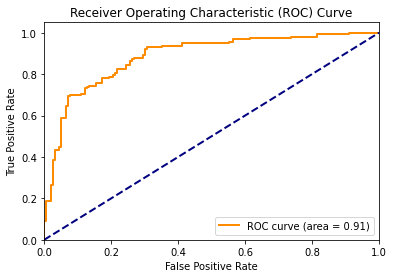

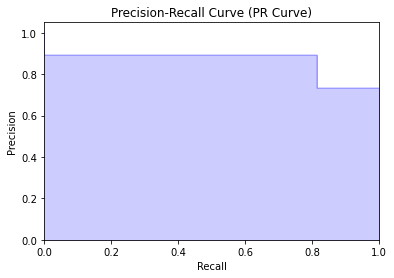

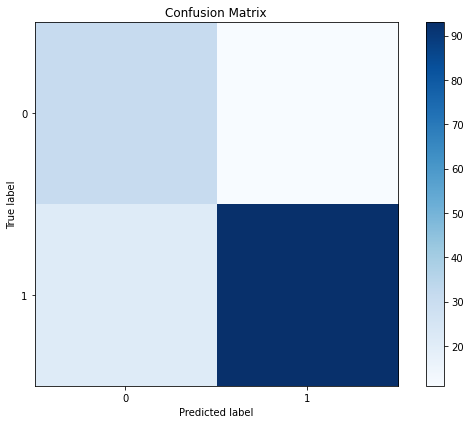

Best Test Accuracy: 0.8526
Best Test AUC: 0.9062
AUPR: 0.9223
Precision: 0.8750
Recall: 0.6053
F1 Score: 0.8532


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve, auc, confusion_matrix

#Extracted best test accuracy and test AUC values
best_test_accuracy = best_accuracy
best_test_auc = best_auc

#Compute precision, recall, and F1 score
precision, recall, _ = precision_recall_curve(test_targets, np.argmax(test_outputs_proba, axis=1))
f1 = f1_score(test_targets, np.argmax(test_outputs_proba, axis=1))

#Compute ROC curve
fpr, tpr, _ = roc_curve(test_targets_onehot.ravel(), test_outputs_proba.ravel())

#Compute AUPR
aupr = auc(recall, precision)

#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % best_test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Plot PR curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (PR Curve)')
plt.show()

#Compute and plot confusion matrix
cm = confusion_matrix(test_targets, np.argmax(test_outputs_proba, axis=1))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes))
plt.yticks(tick_marks, range(n_classes))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#Print computed metrics
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")
print(f"Best Test AUC: {best_test_auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print(f"Precision: {precision.mean():.4f}")
print(f"Recall: {recall.mean():.4f}")
print(f"F1 Score: {f1:.4f}")


In [23]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn import metrics
import numpy as np

def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, patience):
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        #Validate the model
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                if task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32)
                    outputs = outputs.softmax(dim=-1)
                else:
                    targets = targets.squeeze().long()
                    outputs = outputs.softmax(dim=-1)
                val_loss += criterion(outputs, targets).sum().item()

        #Early stopping and LR scheduler
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss / len(train_loader.dataset):.4f} | Val Loss: {val_loss:.4f}')

#Create a KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Initialize lists to store results
fold_accuracies = []
fold_aucs = []
fold_f1_scores = []
fold_auprs = []
# Initialize lists to store results for each fold
all_fold_accuracies = []
all_fold_aucs = []
all_fold_f1_scores = []
all_fold_auprs = []

# Perform 5-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    # Split the dataset into train and validation folds
    train_data = Subset(train_dataset, train_idx)
    val_data = Subset(train_dataset, val_idx)
    
    # Create data loaders for the current fold
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=2 * BATCH_SIZE, shuffle=False)
    
    # Initialize the model and optimizer
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
    
    # Train the model on the current fold
    train_model(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS, patience)
    
    # Evaluate the model on the validation fold
    val_outputs = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_outputs.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_outputs_proba = torch.softmax(torch.tensor(val_outputs), dim=1).cpu().numpy()

    # Clip val_targets to valid range
    val_targets = np.clip(val_targets, 0, n_classes - 1)

    # Calculate accuracy and AUC for the current fold
    fold_accuracy = metrics.accuracy_score(val_targets, np.argmax(val_outputs, axis=1))
    fold_auc = metrics.roc_auc_score(val_targets, val_outputs_proba[:, 1])  # Assuming it's a binary classification task

    # Calculate F1 score and AUPR for the current fold
    fold_f1 = metrics.f1_score(val_targets, np.argmax(val_outputs, axis=1), average='macro')
    fold_aupr = metrics.average_precision_score(val_targets, val_outputs_proba[:, 1])

    # Append the results to the lists
    all_fold_accuracies.append(fold_accuracy)
    all_fold_aucs.append(fold_auc)
    all_fold_f1_scores.append(fold_f1)
    all_fold_auprs.append(fold_aupr)

    # Print results for the current fold
    print(f"Accuracy: {fold_accuracy:.4f} | AUC: {fold_auc:.4f} | F1: {fold_f1:.4f} | AUPR: {fold_aupr:.4f}")

# Calculate and print the average accuracy, AUC, F1 score, and AUPR
avg_accuracy = sum(all_fold_accuracies) / len(all_fold_accuracies)
avg_auc = sum(all_fold_aucs) / len(all_fold_aucs)
avg_f1 = sum(all_fold_f1_scores) / len(all_fold_f1_scores)
avg_aupr = sum(all_fold_auprs) / len(all_fold_auprs)

# Print all fold results
print("\nAll Fold Results:")
for i in range(len(all_fold_accuracies)):
    print(f"Fold {i + 1}: Accuracy: {all_fold_accuracies[i]:.4f} | AUC: {all_fold_aucs[i]:.4f} | F1: {all_fold_f1_scores[i]:.4f} | AUPR: {all_fold_auprs[i]:.4f}")

print(" ")
print(f"Average Accuracy: {avg_accuracy:.4f} | Average AUC: {avg_auc:.4f} | Average F1: {avg_f1:.4f} | Average AUPR: {avg_aupr:.4f}")


C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.24it/s]


Epoch 1/30 | Train Loss: 0.6610 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.63it/s]


Epoch 2/30 | Train Loss: 0.5833 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.68it/s]


Epoch 3/30 | Train Loss: 0.5318 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.71it/s]


Epoch 4/30 | Train Loss: 0.5502 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.74it/s]


Epoch 5/30 | Train Loss: 0.5223 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.60it/s]


Epoch 6/30 | Train Loss: 0.4636 | Val Loss: 0.0105


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.76it/s]


Epoch 7/30 | Train Loss: 0.4317 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.71it/s]


Epoch 8/30 | Train Loss: 0.4462 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.69it/s]


Epoch 9/30 | Train Loss: 0.4162 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.52it/s]


Epoch 10/30 | Train Loss: 0.3841 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.73it/s]


Epoch 11/30 | Train Loss: 0.3594 | Val Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.67it/s]


Epoch 12/30 | Train Loss: 0.3252 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.63it/s]


Epoch 13/30 | Train Loss: 0.2999 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.58it/s]


Epoch 14/30 | Train Loss: 0.2799 | Val Loss: 0.0106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.51it/s]


Epoch 15/30 | Train Loss: 0.2997 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.52it/s]


Epoch 16/30 | Train Loss: 0.2808 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.55it/s]


Epoch 17/30 | Train Loss: 0.2844 | Val Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.37it/s]


Epoch 18/30 | Train Loss: 0.3205 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.50it/s]


Epoch 19/30 | Train Loss: 0.2672 | Val Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.47it/s]


Epoch 20/30 | Train Loss: 0.2427 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.49it/s]


Epoch 21/30 | Train Loss: 0.2416 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.44it/s]


Epoch 22/30 | Train Loss: 0.1686 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.37it/s]


Epoch 23/30 | Train Loss: 0.2261 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.55it/s]


Epoch 24/30 | Train Loss: 0.2689 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.30it/s]


Epoch 25/30 | Train Loss: 0.2136 | Val Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.32it/s]


Epoch 26/30 | Train Loss: 0.2341 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.43it/s]


Epoch 27/30 | Train Loss: 0.2273 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.37it/s]


Epoch 28/30 | Train Loss: 0.1669 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.24it/s]


Epoch 29/30 | Train Loss: 0.1926 | Val Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.92it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 30/30 | Train Loss: 0.1452 | Val Loss: 0.0086
Accuracy: 0.8364 | AUC: 0.8353 | F1: 0.7602 | AUPR: 0.9441
Fold 2


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.40it/s]


Epoch 1/30 | Train Loss: 0.8051 | Val Loss: 0.0112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.15it/s]


Epoch 2/30 | Train Loss: 0.5740 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.41it/s]


Epoch 3/30 | Train Loss: 0.5542 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.34it/s]


Epoch 4/30 | Train Loss: 0.5452 | Val Loss: 0.0105


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.44it/s]


Epoch 5/30 | Train Loss: 0.4997 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.57it/s]


Epoch 6/30 | Train Loss: 0.4514 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.30it/s]


Epoch 7/30 | Train Loss: 0.4303 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.27it/s]


Epoch 8/30 | Train Loss: 0.4308 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.21it/s]


Epoch 9/30 | Train Loss: 0.3841 | Val Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.35it/s]


Epoch 10/30 | Train Loss: 0.3948 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.36it/s]


Epoch 11/30 | Train Loss: 0.4004 | Val Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.48it/s]


Epoch 12/30 | Train Loss: 0.3474 | Val Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.29it/s]


Epoch 13/30 | Train Loss: 0.3085 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.98it/s]


Epoch 14/30 | Train Loss: 0.3197 | Val Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.01it/s]


Epoch 15/30 | Train Loss: 0.2900 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.09it/s]


Epoch 16/30 | Train Loss: 0.2641 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 17/30 | Train Loss: 0.2687 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.24it/s]


Epoch 18/30 | Train Loss: 0.2441 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.20it/s]


Epoch 19/30 | Train Loss: 0.2175 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.11it/s]


Epoch 20/30 | Train Loss: 0.2020 | Val Loss: 0.0084


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.31it/s]


Epoch 21/30 | Train Loss: 0.2023 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.98it/s]


Epoch 22/30 | Train Loss: 0.1706 | Val Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.92it/s]


Epoch 23/30 | Train Loss: 0.2524 | Val Loss: 0.0083


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.94it/s]


Epoch 24/30 | Train Loss: 0.2022 | Val Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.99it/s]


Epoch 25/30 | Train Loss: 0.1694 | Val Loss: 0.0084


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.25it/s]


Epoch 26/30 | Train Loss: 0.2034 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.14it/s]


Epoch 27/30 | Train Loss: 0.1465 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.06it/s]


Epoch 28/30 | Train Loss: 0.1743 | Val Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.77it/s]


Epoch 29/30 | Train Loss: 0.2045 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.82it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 30/30 | Train Loss: 0.1729 | Val Loss: 0.0079
Accuracy: 0.8440 | AUC: 0.9029 | F1: 0.7694 | AUPR: 0.9693
Fold 3


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.77it/s]


Epoch 1/30 | Train Loss: 0.7267 | Val Loss: 0.0110


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.98it/s]


Epoch 2/30 | Train Loss: 0.5665 | Val Loss: 0.0108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.01it/s]


Epoch 3/30 | Train Loss: 0.5291 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.91it/s]


Epoch 4/30 | Train Loss: 0.4668 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.95it/s]


Epoch 5/30 | Train Loss: 0.4793 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.98it/s]


Epoch 6/30 | Train Loss: 0.4413 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 7/30 | Train Loss: 0.4203 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.13it/s]


Epoch 8/30 | Train Loss: 0.3776 | Val Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 9/30 | Train Loss: 0.3522 | Val Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.01it/s]


Epoch 10/30 | Train Loss: 0.3463 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.92it/s]


Epoch 11/30 | Train Loss: 0.3418 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch 12/30 | Train Loss: 0.3468 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.94it/s]


Epoch 13/30 | Train Loss: 0.2779 | Val Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.00it/s]


Epoch 14/30 | Train Loss: 0.2541 | Val Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.80it/s]


Epoch 15/30 | Train Loss: 0.2429 | Val Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.00it/s]


Epoch 16/30 | Train Loss: 0.2207 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.92it/s]


Epoch 17/30 | Train Loss: 0.2414 | Val Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.84it/s]


Epoch 18/30 | Train Loss: 0.2324 | Val Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.79it/s]


Epoch 19/30 | Train Loss: 0.2061 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.56it/s]


Epoch 20/30 | Train Loss: 0.1978 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.52it/s]


Epoch 21/30 | Train Loss: 0.2003 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.72it/s]


Epoch 22/30 | Train Loss: 0.1821 | Val Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch 23/30 | Train Loss: 0.2381 | Val Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.71it/s]


Epoch 24/30 | Train Loss: 0.1980 | Val Loss: 0.0084


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.70it/s]


Epoch 25/30 | Train Loss: 0.1121 | Val Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.89it/s]


Epoch 26/30 | Train Loss: 0.1519 | Val Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.81it/s]


Epoch 27/30 | Train Loss: 0.2093 | Val Loss: 0.0082


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.68it/s]


Epoch 28/30 | Train Loss: 0.1280 | Val Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.60it/s]


Epoch 29/30 | Train Loss: 0.1678 | Val Loss: 0.0084


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.63it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 30/30 | Train Loss: 0.1645 | Val Loss: 0.0087
Accuracy: 0.8349 | AUC: 0.8508 | F1: 0.7596 | AUPR: 0.9325
Fold 4


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.09it/s]


Epoch 1/30 | Train Loss: 1.0451 | Val Loss: 0.0132


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.12it/s]


Epoch 2/30 | Train Loss: 0.5661 | Val Loss: 0.0128


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.04it/s]


Epoch 3/30 | Train Loss: 0.4973 | Val Loss: 0.0119


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.03it/s]


Epoch 4/30 | Train Loss: 0.4543 | Val Loss: 0.0111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.94it/s]


Epoch 5/30 | Train Loss: 0.4136 | Val Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.06it/s]


Epoch 6/30 | Train Loss: 0.4184 | Val Loss: 0.0109


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.03it/s]


Epoch 7/30 | Train Loss: 0.3908 | Val Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 8/30 | Train Loss: 0.3738 | Val Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.14it/s]


Epoch 9/30 | Train Loss: 0.3800 | Val Loss: 0.0103


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 10/30 | Train Loss: 0.3592 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.04it/s]


Epoch 11/30 | Train Loss: 0.3182 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.15it/s]


Epoch 12/30 | Train Loss: 0.3032 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 13/30 | Train Loss: 0.3150 | Val Loss: 0.0105


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.11it/s]


Epoch 14/30 | Train Loss: 0.3266 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.09it/s]


Epoch 15/30 | Train Loss: 0.3022 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.05it/s]


Epoch 16/30 | Train Loss: 0.2815 | Val Loss: 0.0106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.17it/s]


Epoch 17/30 | Train Loss: 0.2604 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.15it/s]


Epoch 18/30 | Train Loss: 0.2102 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.02it/s]


Epoch 19/30 | Train Loss: 0.2391 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 20/30 | Train Loss: 0.2319 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.77it/s]


Epoch 21/30 | Train Loss: 0.2049 | Val Loss: 0.0098


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.15it/s]
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\agodw\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Early stopping!
Accuracy: 0.7248 | AUC: 0.7975 | F1: 0.6619 | AUPR: 0.8868
Fold 5


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.76it/s]


Epoch 1/30 | Train Loss: 0.6721 | Val Loss: 0.0125


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.77it/s]


Epoch 2/30 | Train Loss: 0.5530 | Val Loss: 0.0117


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.82it/s]


Epoch 3/30 | Train Loss: 0.5116 | Val Loss: 0.0120


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.75it/s]


Epoch 4/30 | Train Loss: 0.5036 | Val Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.82it/s]


Epoch 5/30 | Train Loss: 0.4816 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 6/30 | Train Loss: 0.4547 | Val Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.71it/s]


Epoch 7/30 | Train Loss: 0.4607 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.84it/s]


Epoch 8/30 | Train Loss: 0.4431 | Val Loss: 0.0105


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.73it/s]


Epoch 9/30 | Train Loss: 0.3806 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.88it/s]


Epoch 10/30 | Train Loss: 0.3514 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.67it/s]


Epoch 11/30 | Train Loss: 0.3148 | Val Loss: 0.0103


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 12/30 | Train Loss: 0.3242 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.95it/s]


Epoch 13/30 | Train Loss: 0.3233 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.89it/s]


Epoch 14/30 | Train Loss: 0.2598 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.87it/s]


Epoch 15/30 | Train Loss: 0.2800 | Val Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.91it/s]


Epoch 16/30 | Train Loss: 0.2096 | Val Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.72it/s]


Epoch 17/30 | Train Loss: 0.2643 | Val Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.74it/s]


Epoch 18/30 | Train Loss: 0.2783 | Val Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.73it/s]


Epoch 19/30 | Train Loss: 0.2357 | Val Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.05it/s]


Epoch 20/30 | Train Loss: 0.2324 | Val Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.89it/s]


Epoch 21/30 | Train Loss: 0.1675 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.00it/s]


Epoch 22/30 | Train Loss: 0.2149 | Val Loss: 0.0100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.98it/s]


Epoch 23/30 | Train Loss: 0.1458 | Val Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 24/30 | Train Loss: 0.1675 | Val Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.93it/s]


Epoch 25/30 | Train Loss: 0.1574 | Val Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.73it/s]


Epoch 26/30 | Train Loss: 0.1679 | Val Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.62it/s]


Epoch 27/30 | Train Loss: 0.1788 | Val Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.74it/s]


Early stopping!
Accuracy: 0.8349 | AUC: 0.8197 | F1: 0.7971 | AUPR: 0.9076

All Fold Results:
Fold 1: Accuracy: 0.8364 | AUC: 0.8353 | F1: 0.7602 | AUPR: 0.9441
Fold 2: Accuracy: 0.8440 | AUC: 0.9029 | F1: 0.7694 | AUPR: 0.9693
Fold 3: Accuracy: 0.8349 | AUC: 0.8508 | F1: 0.7596 | AUPR: 0.9325
Fold 4: Accuracy: 0.7248 | AUC: 0.7975 | F1: 0.6619 | AUPR: 0.8868
Fold 5: Accuracy: 0.8349 | AUC: 0.8197 | F1: 0.7971 | AUPR: 0.9076
 
Average Accuracy: 0.8150 | Average AUC: 0.8412 | Average F1: 0.7496 | Average AUPR: 0.9280
